In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data preprocessing

In [2]:
# load data
df = pd.DataFrame()

for path in glob.glob("data/*.RData"):
    _df = pyreadr.read_r(path)
    k = list(_df.keys())[0]
    _df =  _df[k]
    df = pd.concat([df, _df])

df = df.reset_index()
df

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1.0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,1.0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,2,1.0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,3,1.0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,4,1.0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329995,479995,0.0,500.0,956,0.26428,3671.5,4510.8,9.2852,27.141,42.297,...,53.942,26.022,61.709,22.417,40.510,36.731,50.115,52.721,40.927,18.854
15329996,479996,0.0,500.0,957,0.25132,3573.4,4483.9,9.2872,26.604,42.311,...,53.760,24.585,61.267,21.928,39.893,34.136,47.714,52.908,41.412,18.847
15329997,479997,0.0,500.0,958,0.25105,3622.6,4433.3,9.3998,26.707,41.936,...,54.366,24.613,61.745,22.212,40.098,35.585,48.241,53.099,40.150,16.791
15329998,479998,0.0,500.0,959,0.24521,3660.5,4485.2,9.3885,26.936,42.639,...,53.289,24.371,62.811,22.249,39.536,35.609,46.495,53.157,41.065,17.097


In [3]:
# preprocess data
df["faultNumber"] = df["faultNumber"].astype(int)
df = df.drop(["simulationRun", "sample", "index"], axis=1)

In [4]:
# remove 3, 9 and 15
mask = ~df["faultNumber"].isin([3, 9, 15])

In [5]:
df = df[mask]
df["faultNumber"].unique()

array([ 1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
        0])

In [6]:
# features
X = df.loc[:, df.columns != "faultNumber"].values
# labels
y = df["faultNumber"].values

X.shape, y.shape

((13140000, 52), (13140000,))

In [7]:
df.columns[df.columns != "faultNumber"]

Index(['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11'],
      dtype='object')

In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X.shape

(13140000, 52)

In [9]:
scaled_df = pd.DataFrame(scaled_X, columns=df.columns[df.columns != "faultNumber"])
scaled_df.head(3)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.048403,0.172463,-0.370896,0.317190,0.674038,0.295625,-0.255480,-0.073291,0.133912,-0.109065,...,-0.023099,-0.276875,-0.466629,-0.071480,0.052982,0.688629,0.655752,-0.156733,-0.000211,-0.485108
1,-0.044249,-0.510475,0.523796,0.069667,0.422894,0.638373,-0.260356,0.202214,-0.273659,-0.090802,...,-0.191197,-0.279855,-0.380834,-0.067129,0.039000,-0.476264,-0.587066,-0.145792,-0.130463,-0.397765
2,-0.070227,-0.490122,-0.010922,-0.245500,0.111128,-0.295842,-0.281081,-0.227164,-0.273659,-0.102173,...,-0.090887,-0.260867,-0.360861,-0.083757,0.047548,1.299152,-0.793705,-0.147038,-0.064116,0.136149


In [10]:
scaled_df.describe()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,...,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07
mean,-3.357430e-15,1.076080e-13,-1.378798e-14,1.229276e-15,7.041854e-14,2.432180e-14,9.094791e-15,1.181620e-14,3.622382e-13,-1.088897e-15,...,-2.193034e-14,-4.550837e-16,1.487936e-14,2.797783e-15,3.200637e-16,-1.489629e-14,2.200443e-14,-2.173475e-15,-4.599987e-15,-1.466808e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.740879e+00,-8.058969e+00,-8.458078e+00,-6.959772e+00,-6.726066e+00,-8.248797e+00,-3.812835e+00,-1.005158e+01,-1.073464e+01,-3.762003e+00,...,-6.492572e+00,-1.473142e+00,-7.243393e+00,-1.816945e+00,-2.855521e+00,-5.364186e+00,-5.558764e+00,-2.755571e+00,-3.588298e+00,-2.352624e+00
25%,-2.778506e-01,-6.325895e-01,-3.394423e-01,-3.047835e-01,-5.990048e-01,-5.718597e-01,-3.505700e-01,-3.180223e-01,-2.736590e-01,-2.699887e-01,...,-1.584009e-01,-3.899846e-01,-3.967221e-01,-1.437417e-01,-8.705024e-02,-6.947449e-01,-6.641828e-01,-2.670049e-01,-1.289475e-01,-2.688179e-01
50%,-5.512817e-02,-2.201628e-02,3.930875e-03,-7.474204e-02,-5.783974e-03,-7.442083e-02,-2.554797e-01,6.812522e-02,-1.945255e-03,-1.143486e-01,...,-9.376873e-02,-2.452922e-01,-2.602000e-01,-8.973954e-02,3.639215e-02,2.637937e-02,-4.895167e-02,-1.139454e-01,-7.539861e-02,-1.264895e-01
75%,1.561219e-01,5.953411e-01,3.560413e-01,1.917818e-01,6.047572e-01,4.715487e-01,-1.396645e-01,4.220327e-01,2.697684e-01,2.877147e-02,...,-2.748989e-02,-7.411293e-02,-1.013214e-01,-4.265276e-02,1.483161e-01,6.474515e-01,6.757770e-01,9.879972e-02,-1.081993e-02,2.763879e-02
max,5.000698e+00,5.470881e+00,5.828169e+00,7.228061e+00,7.203797e+00,6.907922e+00,3.339668e+00,9.041109e+00,8.285323e+00,5.453893e+00,...,6.221384e+00,3.361250e+00,4.107940e+00,5.970003e+00,4.209672e+00,5.506107e+00,5.879678e+00,2.728975e+00,4.926123e+00,9.814238e+00


In [11]:
def create_samples(X, y, lookback=5):
    x_out = []
    y_out = []
    with tqdm(total=len(X)-lookback-1) as pbar:
        for i in range(len(X)-lookback-1):
            _x = X[i:i+lookback, :]
            _y = y[i+lookback+1]
            x_out.append(_x)
            y_out.append(_y)
            pbar.update(1)

    print("Preparing numpy return. This could take some seconds.")
    return np.array(x_out), np.array(y_out)

In [12]:
_x, _y = create_samples(scaled_df.values, y)
_x.shape, _y.shape

100%|██████████| 13139994/13139994 [00:10<00:00, 1251313.21it/s]


Preparing numpy return. This could take some seconds.


((13139994, 5, 52), (13139994,))

### Scaler
The recommended way (see 'Elements of Statistical Learning', chapter 'The Wrong and Right Way to Do Cross-validation') is to calculate the **mean** and the **standard deviation** of the values in the **training set** and then **apply them for standardizing both the training and testing sets**.

The idea behind this is to preven**t data leaka**ge from the testing to the training set because the aim of model validation is to subject the testing data to the same conditions as the data used for the model training.

[Link](https://datascience.stackexchange.com/questions/63717/how-to-use-standardization-standardscaler-for-train-and-test)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, random_state=1)

# LSTM VAE

### Encoder

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return hidden_state

### Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        # reconstruction
        self.linear_recon = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return self.linear_recon(output)

### VAE

In [17]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, device):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.device = device

        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        ).to(self.device)

        self.decoder = Decoder(
            input_size=latent_size, # compressed vector size
            hidden_size=hidden_size,
            output_size=input_size, # reconstruction of features at timestep
            num_layers=num_layers
        ).to(self.device)

        self.mean_linear = nn.Linear((self.hidden_size*self.num_layers), self.latent_size).to(self.device)
        self.logvar_linear = nn.Linear((self.hidden_size*self.num_layers), self.latent_size).to(self.device)
        #self.compressed_linear = nn.Linear(self.latent_size, self.hidden_size).to(self.device)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        # Gaussian (normal)
        noise = torch.randn_like(std, device=self.device)
        return mu + (noise * std)

    def forward(self, X):
        batch_size, seq_len, features_dim = X.shape

        # encode
        # tensor of shape: 1*num_layers, batch_size, hidden_size
        enc_hidden = self.encoder(X)
        enc_hidden = enc_hidden.transpose(0, 1).contiguous().view(batch_size, -1) # (batch_size, hidden_size*num_layers)

        # extract latent variable z (hidden to latent)
        _mean = self.mean_linear(enc_hidden)
        _logvar = self.logvar_linear(enc_hidden)
        _z = self.reparametrize(_mean, _logvar) # Shape: batch_size, latent_size
        _z = _z.unsqueeze(1).repeat(1, seq_len, 1)

        # hidden state
        #_h = self.compressed_linear(_z) # batch_size, hidden_size
        #_h = _h.unsqueeze(1).repeat(1, seq_len, 1)

        pred = self.decoder(_z)

        return pred, _mean, _logvar


In [18]:
def vae_loss(pred, label, _mean, _logvar):
    #reconstruction_loss = nn.BCELoss(pred, label)
    reconstruction_loss = F.mse_loss(pred, label)
    kld_loss = torch.mean(
            -0.5 * torch.sum(1 + _logvar - _mean**2 - _logvar.exp(), dim=1), dim=0
        )
    loss = reconstruction_loss + kld_loss #*kld_weight
    return loss, reconstruction_loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
class TEP(Dataset):
    def __init__(self, x, y):
        super(TEP, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        _x = self.x[idx]
        _y = self.y[idx]
        return _x, _y

In [64]:
train_data = TEP(X_train[:50_000], y_train[:50_000])
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [65]:
test_data = TEP(X_test[:3_000], y_test[:3_000])
testloader = DataLoader(test_data, batch_size=256)

In [78]:
num_epochs = 10

# model
learning_rate = 0.0002
model = VAE(input_size=52, hidden_size=128, latent_size=32, num_layers=12, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

model.train()
train_losses = []
test_losses = []
for i in range(num_epochs):
    _train_losses = []
    _test_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        for x, y in trainloader:
            x = x.to(torch.float32).to(device)
            pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _r = loss.detach().item()
            _train_losses.append(_r)

            pbar.update(1)
        
        for x, y in testloader:
            x = x.to(torch.float32).to(device)
            with torch.no_grad():
                pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)
            _r = loss.detach().item()
            _test_losses.append(_r)

        # epoch losses
        e_train = np.mean(_train_losses)
        e_test = np.mean(_test_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
            
                
        print(f"Epoch {i+1} - train loss: {e_train} - test loss: {e_test}")
        torch.save(model.state_dict(), "./model/model.pt")
        torch.save(optimizer.state_dict(), "./model/optimizer.pt")

100%|██████████| 196/196 [00:08<00:00, 22.58it/s]


Epoch 1 - train loss: 1.0262211615941963 - test loss: 1.0440128992001216


100%|██████████| 196/196 [00:08<00:00, 22.59it/s]


Epoch 2 - train loss: 1.019563110203159 - test loss: 1.040674274166425


100%|██████████| 196/196 [00:08<00:00, 22.53it/s]


Epoch 3 - train loss: 1.0173175973551614 - test loss: 1.0393550793329875


100%|██████████| 196/196 [00:08<00:00, 22.40it/s]


Epoch 4 - train loss: 1.0158756478708617 - test loss: 1.038510615626971


100%|██████████| 196/196 [00:08<00:00, 22.42it/s]


Epoch 5 - train loss: 1.015900888309187 - test loss: 1.0378666917483013


100%|██████████| 196/196 [00:08<00:00, 22.54it/s]


Epoch 6 - train loss: 1.01357140559323 - test loss: 1.0373390465974808


100%|██████████| 196/196 [00:08<00:00, 22.53it/s]


Epoch 7 - train loss: 1.0146201493180529 - test loss: 1.036892871061961


100%|██████████| 196/196 [00:08<00:00, 22.40it/s]


Epoch 8 - train loss: 1.0134001958126924 - test loss: 1.0365051726500194


100%|██████████| 196/196 [00:08<00:00, 22.53it/s]


Epoch 9 - train loss: 1.0124033805058927 - test loss: 1.0361658036708832


100%|██████████| 196/196 [00:08<00:00, 22.54it/s]

Epoch 10 - train loss: 1.0128131980190471 - test loss: 1.0358630518118541


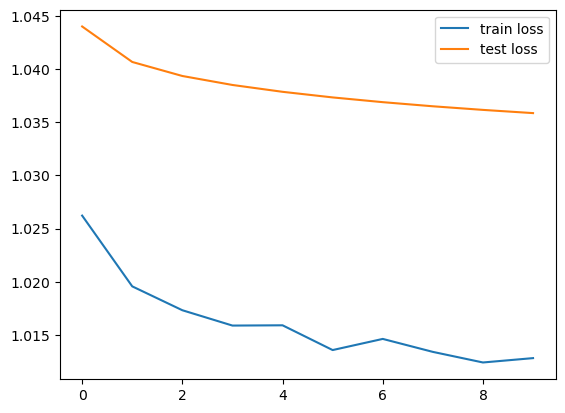

In [79]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()